# Data simulation for Section 3.4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle as pkl
from haplm.hap_util import mat_by_marker, num_to_str

In [2]:
from matplotlib import rc, rcParams

# comment out if tex is not installed
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=14)

# colors for plotting
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

In [3]:
def sigmoid_h(t, t0, scale, mag):
    return mag/(1+np.exp(-(t-t0)/scale))

In [4]:
S = 4 # number of changepoints
H = 8
Tmax = 20
pool_size = 50
valid = 0

rng = np.random.default_rng(0)
first = True
while valid < 100:
    scale_mat = 0.2 + 1.8*rng.random((H,S)) # horizontal stretch of each sigmoid

    t0_mat = rng.random((H, S))*Tmax
    t0_mat.sort(axis=-1)

    hs = rng.normal(scale=1/np.diff(np.hstack([np.zeros((H,1)), t0_mat, np.ones((H,1))*Tmax]), axis=1),
                          size=(H,S+1)) # heights
    h0 = hs[:,0] # initial heights
    mag_mat = np.diff(hs, axis=-1) # magnitude of each sigmoid


    pop0 = np.ones(H)
    tf = Tmax
    dt = 0.001
    ts = np.arange(0, tf+dt/2, dt)
    T = len(ts)
    res = scipy.integrate.solve_ivp(lambda t, y: y*np.array([h0[i] + np.sum(sigmoid_h(t, t0_mat[i], scale_mat[i], mag_mat[i]))
                                                             for i in range(H)]),
                    (0, tf), pop0,
                    t_eval=ts)
    if res.status:
        # did not solve successfully
        continue
    
    # set initial values in a way such that no multinomial class overdominates / is overdominated
    scaled = res.y / np.median(res.y, axis=1)[:,None]
    p_cand = scaled / scaled.sum(axis=0)
    
    is_valid = (np.abs(np.diff(p_cand, axis=1)/dt).max() < 0.2
                and p_cand.min() > 0
                and p_cand.max() < 1)
    valid += is_valid
    if not is_valid:
        continue
        
    val = np.sum(np.mean(np.abs(np.diff(p_cand[:,5000:16000:1000], axis=1)), axis=1))
    is_valid = (np.abs(np.diff(p_cand, axis=1)/dt).max() < 1
                and p_cand.min() > 0
                and p_cand.max() < 1)
    
    if first or val > best:
        first = False
        best = val
        p_best = p_cand

In [5]:
# t_idx = np.sort(rng.choice(np.arange(ts.size * 9 // 10), size=N, replace=True)) + ts.size // Tmax
t_idx = np.arange(430, 20000, 660)
t_obs = t_idx / 1000
N = len(t_obs)

In [6]:
reorder = [3, 5, 7, 0, 1, 6, 2, 4] # reorder classes such that minor alleles are rarer than major alleles
rng = np.random.default_rng(0)
p_true = p_best[reorder]
zs_true = np.array([rng.multinomial(pool_size, rng.dirichlet(200*p_true[:,ti])) for ti in t_idx])

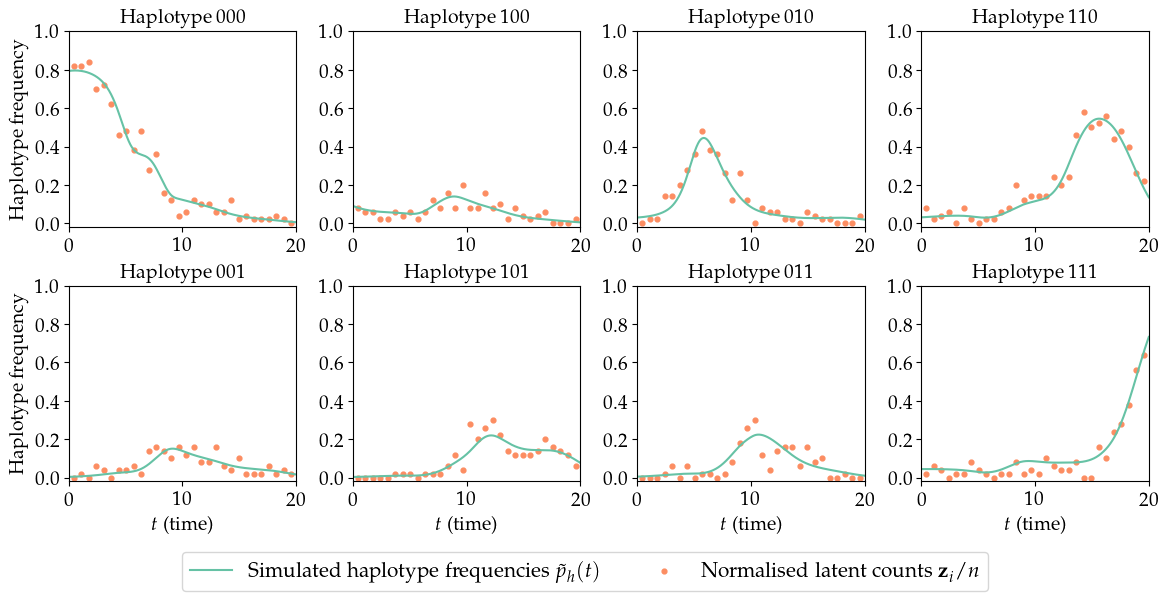

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for i in range(H):
    ax = axes[i//4][i%4] 
    ax.plot(res.t, p_true[i], color=colors[0], label=r'Simulated haplotype frequencies $\tilde{p}_h(t)$')
    ax.scatter(t_obs, zs_true[:,i]/pool_size, color=colors[1], s=12, label=r'Normalised latent counts $\mathbf{z}_{i}/n$')
    #ax.plot(res.t, h0[i] + [np.sum(sigmoid_h(t, t0_mat[i], scale_mat[i], mag_mat[i])) for t in ts])
    ax.set_ylim(-0.02, 1)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xlabel('$t$ (time)', fontsize=14)
    ax.set_xticks(np.arange(0,21,10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    ax.set_yticks(np.arange(0,1.01,0.2))
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=14)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.95, bottom=0.2, left=0.07, right=0.97, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_hap_raw.png', dpi=200, facecolor='white');

In [8]:
amat = mat_by_marker(3)
ys = (amat @ zs_true.T).T

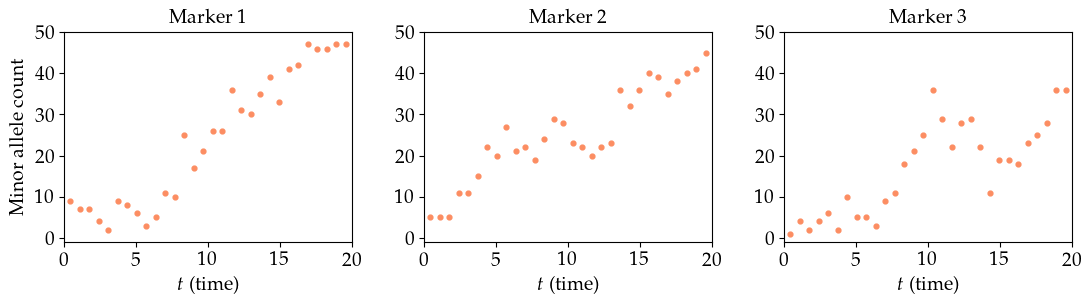

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
for i in range(3):
    ax = axes[i]
    # ax.plot(res.t, (amat @ p_true)[i],
    #         color=colors[0], label=r'Simulated marker frequencies')
    ax.scatter(t_obs, ys[:,i],
               color=colors[1], s=12, label=r'Observed counts $\mathbf{y}_i$')
    ax.set_ylim(-1, 50)
    ax.set_xlim(0, 20)
    ax.set_xlabel('$t$ (time)', fontsize=14)
    if i == 0:
        ax.set_ylabel(f'Minor allele count', fontsize=14)
    ax.set_yticks(np.arange(0,51,10))
    ax.set_title(f'Marker {i+1}', fontsize=14)
    
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.9, bottom=0.2, left=0.1, right=0.94, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_geno_raw.png', dpi=200, facecolor='white');

In [10]:
with open('../../data/time-series/time_series.data', 'w') as fp:
    for i in range(N):
        fp.write(f'{t_obs[i]:.3f} {pool_size} ')
        fp.write(' '.join([str(y) for y in ys[i]]))
        fp.write('\n')

In [11]:
with open('../../data/time-series/sim_data.pkl', 'wb') as fp:
    pkl.dump({'p': p_true, 'z': zs_true}, fp)